In [10]:
from pathlib import Path
import json
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load human eval annotations

In [6]:
# store human eval annotations in this data structure:
# {model: {annotator: {topic: {score: int } } } }
annotations = defaultdict(
    lambda: defaultdict(
        lambda: defaultdict(dict)
    )
) 

for annotated_samples_f in Path("keyword_eval").glob("*/*.json"):
    a = annotated_samples_f.parent.name # annotator id
    m = annotated_samples_f.stem # model id
    for t, sample in json.loads(annotated_samples_f.read_text()).items():
        t = t.split("_")[-1]
        if sample['interpretability'] == '' or sample['usefulness'] == '':
            print(f"Missing scores for [model {m}][annotator {a}][topic {t}]")
        annotations[m][a][t]["interpretability"] = sample["interpretability"]
        annotations[m][a][t]["usefulness"] = sample["usefulness"]

## Normalize annotation scores

In [7]:
for m in annotations.keys():
    for a in annotations[m].keys():
        for t in annotations[m][a].keys():
            intrp = int(annotations[m][a][t]["interpretability"])
            annotations[m][a][t]["Interpretability"] = (3 - intrp)/2
            annotations[m][a][t]["High Interpretability"] = 0
            annotations[m][a][t]["Avg Interpretability"] = 0
            annotations[m][a][t]["Low Interpretability"] = 0 
            if intrp == 1:
                annotations[m][a][t]["High Interpretability"] = 1
            elif intrp == 2:
                annotations[m][a][t]["Avg Interpretability"] = 1
            elif intrp == 3:
                annotations[m][a][t]["Low Interpretability"] = 1
            else:
                print("Intepretability not valid")
                
            usfl = int(annotations[m][a][t]["usefulness"])
            annotations[m][a][t]["Usefulness"] = (3 - usfl)/2
            annotations[m][a][t]["High Usefulness"] = 0
            annotations[m][a][t]["Avg Usefulness"] = 0
            annotations[m][a][t]["Low Usefulness"] = 0 
            if usfl == 1:
                annotations[m][a][t]["High Usefulness"] = 1
            elif usfl == 2:
                annotations[m][a][t]["Avg Usefulness"] = 1
            elif usfl == 3:
                annotations[m][a][t]["Low Usefulness"] = 1
            else:
                print("Usefulness not valid")
  
annotations[m]['0'][t]

{'interpretability': '1',
 'usefulness': '1',
 'Interpretability': 1.0,
 'High Interpretability': 1,
 'Avg Interpretability': 0,
 'Low Interpretability': 0,
 'Usefulness': 1.0,
 'High Usefulness': 1,
 'Avg Usefulness': 0,
 'Low Usefulness': 0}

## Average scores across annotators

In [9]:
# Compute average of normalized/categorized scores  
# (across annotators for a given model and topic)
# and store in this data structure:
# {model: {score: {topic: ...} } } 
avg_scores = defaultdict(
    lambda: defaultdict(
        lambda: defaultdict(list)
    )
)

score_keys = [s for s in annotations[m][a][t].keys() if s not in ['interpretability', 'usefulness']]
for m in annotations.keys():
    for s in score_keys:
        for a in annotations[m].keys():
            for t in annotations[m][a].keys():
                avg_scores[m][s][t] += [annotations[m][a][t][s]]
                
        for t in annotations[m][a].keys():
                avg_scores[m][s][t] = np.mean(avg_scores[m][s][t])

## Plot scores for each topic/model

In [11]:
def plot_model_topic_scores(score: str, models):
    models = {str(v): k for k,v in models.items()}
    rows = []
    index = []
    for m in models.keys():
        index.append(models[m])
        row = avg_scores[m][score]
        rows.append(row)
    df = pd.DataFrame(rows, index=index)
    
    plt.rcParams['figure.figsize'] = [8, 2]
    plt.pcolor(df, cmap='Blues', vmin=0, vmax=1)
    cbar = plt.colorbar(ticks = [0,0.5,1.0])
    cbar.ax.tick_params(labelsize=12)
    cbar.set_ticklabels([0,0.5,1.0])
    plt.yticks(np.arange(0.5, len(df.index), 1), df.index, fontsize=15)
    plt.xticks([], [], fontsize=15)
    plt.xlabel("Topic", fontsize=15)
    plt.show()
    print("Average")
    for i,r in df.iterrows():
        print(f"{i}: {r.mean()}")
    print("Num >0.5")
    for i,r in df.iterrows():
        print(f"{i}: {len(r[r>0.5])}")
    
    return df

In [18]:
models = {
    "LDA": 9,
    "BERT": 14,
    "BTM": 3,
    "FTE": 6,
    "LDA": 9,
}

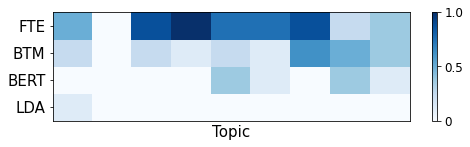

Average
LDA: 0.013888888888888888
BERT: 0.1111111111111111
BTM: 0.2777777777777778
FTE: 0.5972222222222222
Num >0.5
LDA: 0
BERT: 0
BTM: 1
FTE: 5


,0,1,2,3,4,5,6,7,8
LDA,0.125,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000
BERT,0.000,0.0,0.000,0.000,0.375,0.125,0.000,0.375,0.125
BTM,0.250,0.0,0.250,0.125,0.250,0.125,0.625,0.500,0.375
FTE,0.500,0.0,0.875,1.000,0.750,0.750,0.875,0.250,0.375


In [19]:
plot_model_topic_scores("Usefulness", models)

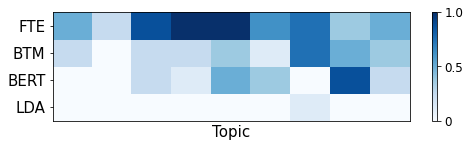

Average
LDA: 0.013888888888888888
BERT: 0.2638888888888889
BTM: 0.3194444444444444
FTE: 0.6527777777777778
Num >0.5
LDA: 0
BERT: 1
BTM: 1
FTE: 5


,0,1,2,3,4,5,6,7,8
LDA,0.00,0.00,0.000,0.000,0.000,0.000,0.125,0.000,0.000
BERT,0.00,0.00,0.250,0.125,0.500,0.375,0.000,0.875,0.250
BTM,0.25,0.00,0.250,0.250,0.375,0.125,0.750,0.500,0.375
FTE,0.50,0.25,0.875,1.000,1.000,0.625,0.750,0.375,0.500


In [20]:
plot_model_topic_scores("Interpretability", models)

## Inter rater agreement (Fleiss Kappa)

In [21]:
annotators = list(annotations[m].keys())
topics = list(sorted(annotations[m][a].keys(), key=lambda x: int(x)))
scores_per_topic = len([annotations[m][a][t]["usefulness"] for t in topics])

fleiss = {
    "u": {m: pd.DataFrame() for m in annotations.keys()}, # useful
    "i": {m: pd.DataFrame() for m in annotations.keys()}, # interpretable
    "u_pi": {},
    "i_pi": {},
    "u_P": {},
    "i_P": {},
    "u_Pe": {},
    "i_Pe": {},
    "k": {}
}


for model, m in models.items():
    m = str(m)
    fleiss["u"][m]["1"] = [0 for _ in range(scores_per_topic)]
    fleiss["u"][m]["2"] = [0 for _ in range(scores_per_topic)]
    fleiss["u"][m]["3"] = [0 for _ in range(scores_per_topic)]
    fleiss["i"][m]["1"] = [0 for _ in range(scores_per_topic)]
    fleiss["i"][m]["2"] = [0 for _ in range(scores_per_topic)]
    fleiss["i"][m]["3"] = [0 for _ in range(scores_per_topic)]
    
    for a in annotators:
        fleiss["u"][m]["1"] += [1 if s=="1" else 0 for t in topics for s in [annotations[m][a][t]["usefulness"]]]
        fleiss["u"][m]["2"] += [1 if s=="2" else 0 for t in topics for s in [annotations[m][a][t]["usefulness"]]]
        fleiss["u"][m]["3"] += [1 if s=="3" else 0 for t in topics for s in [annotations[m][a][t]["usefulness"]]]
        fleiss["i"][m]["1"] += [1 if s=="1" else 0 for t in topics for s in [annotations[m][a][t]["interpretability"]]]
        fleiss["i"][m]["2"] += [1 if s=="2" else 0 for t in topics for s in [annotations[m][a][t]["interpretability"]]]
        fleiss["i"][m]["3"] += [1 if s=="3" else 0 for t in topics for s in [annotations[m][a][t]["interpretability"]]]
        
        

    n = 4 # number of raters  

    N = len(fleiss["u"][m]) # number of subjects

    fleiss["i_pi"][m] = [x/fleiss["i"][m].sum().sum() for x in fleiss["i"][m].sum()]
    fleiss["u_pi"][m] = [x/fleiss["u"][m].sum().sum() for x in fleiss["u"][m].sum()]

    
    fleiss["i"][m]["P_i"] = (1/(n*(n-1))) * (sum([fleiss["i"][m][c] ** 2 for c in fleiss["i"][m].columns]) - n)
    fleiss["u"][m]["P_i"] = (1/(n*(n-1))) * (sum([fleiss["u"][m][c] ** 2 for c in fleiss["u"][m].columns]) - n)

    fleiss["i_P"][m] = fleiss["i"][m]["P_i"].mean()
    fleiss["u_P"][m] = fleiss["u"][m]["P_i"].mean()


    fleiss["i_Pe"][m] = sum([x**2 for x in fleiss["i_pi"][m]])
    fleiss["u_Pe"][m] = sum([x**2 for x in fleiss["u_pi"][m]])
    
    fleiss["k"][m] = {}
    fleiss["k"][m]["i"] = (fleiss["i_P"][m] - fleiss["i_Pe"][m]) / (1 - fleiss["i_Pe"][m])
    fleiss["k"][m]["u"] = (fleiss["u_P"][m] - fleiss["u_Pe"][m]) / (1 - fleiss["u_Pe"][m])

    print(model)
    print(fleiss["k"][m])

LDA
{'i': -0.028571428571426576, 'u': -0.028571428571426576}
BERT
{'i': 0.2646239554317547, 'u': 0.35714285714285715}
BTM
{'i': 0.15014164305948993, 'u': 0.12359550561797747}
FTE
{'i': 0.17974683544303788, 'u': 0.2154963680387411}
